In [1]:
import sys,os,warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow_addons')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

import tensorflow.experimental.numpy as tnp
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision

import src.models.epibert_atac_pretrain as epibert
import training_utils_atac_pretrain as training_utils
from scipy import stats
import kipoiseq
import analysis.interval_and_plotting_utilities as utils
mixed_precision.set_global_policy('mixed_bfloat16')

In [2]:
fasta_file = 'hg38_erccpatch.fa' # make sure you have a fasta file available 
fasta_extractor = utils.FastaStringExtractor(fasta_file)
gtf_file = '/home/jupyter/data/hg38.refGene.gtf'

model1 = epibert.epibert()
model2 = epibert.epibert()
checkpoint1_path="/home/jupyter/models/model1/ckpt-45"
checkpoint2_path="/home/jupyter/models/model2/ckpt-45"
genformer = utils.genformer_model_nostrat(model1,model2,checkpoint1_path, checkpoint2_path)

loaded checkpoints


In [3]:
## scoring a single variant
variant = ('chr12:9764948', 'T') # score an example C -> T transition at position chr12:9764948 in a CD69 enhancer
atac_file="/home/jupyter/data/HG_Jurkat_stim.bed.gz"
motif_activity='/home/jupyter/data/HG_Jurkat_stim.tsv'

In [4]:
inputs, inputs_mut, masked_atac, motif,target_atac, masked_atac_reshape, mask, mask_centered,interval_resize = \
    utils.return_inputs_caqtl_score(variant, atac_file, motif_activity, fasta_extractor)

In [5]:
with tf.device('/GPU:0'): # run on GPU 
    output,output_mut,caqtl_score = genformer.ca_qtl_score(inputs,inputs_mut)

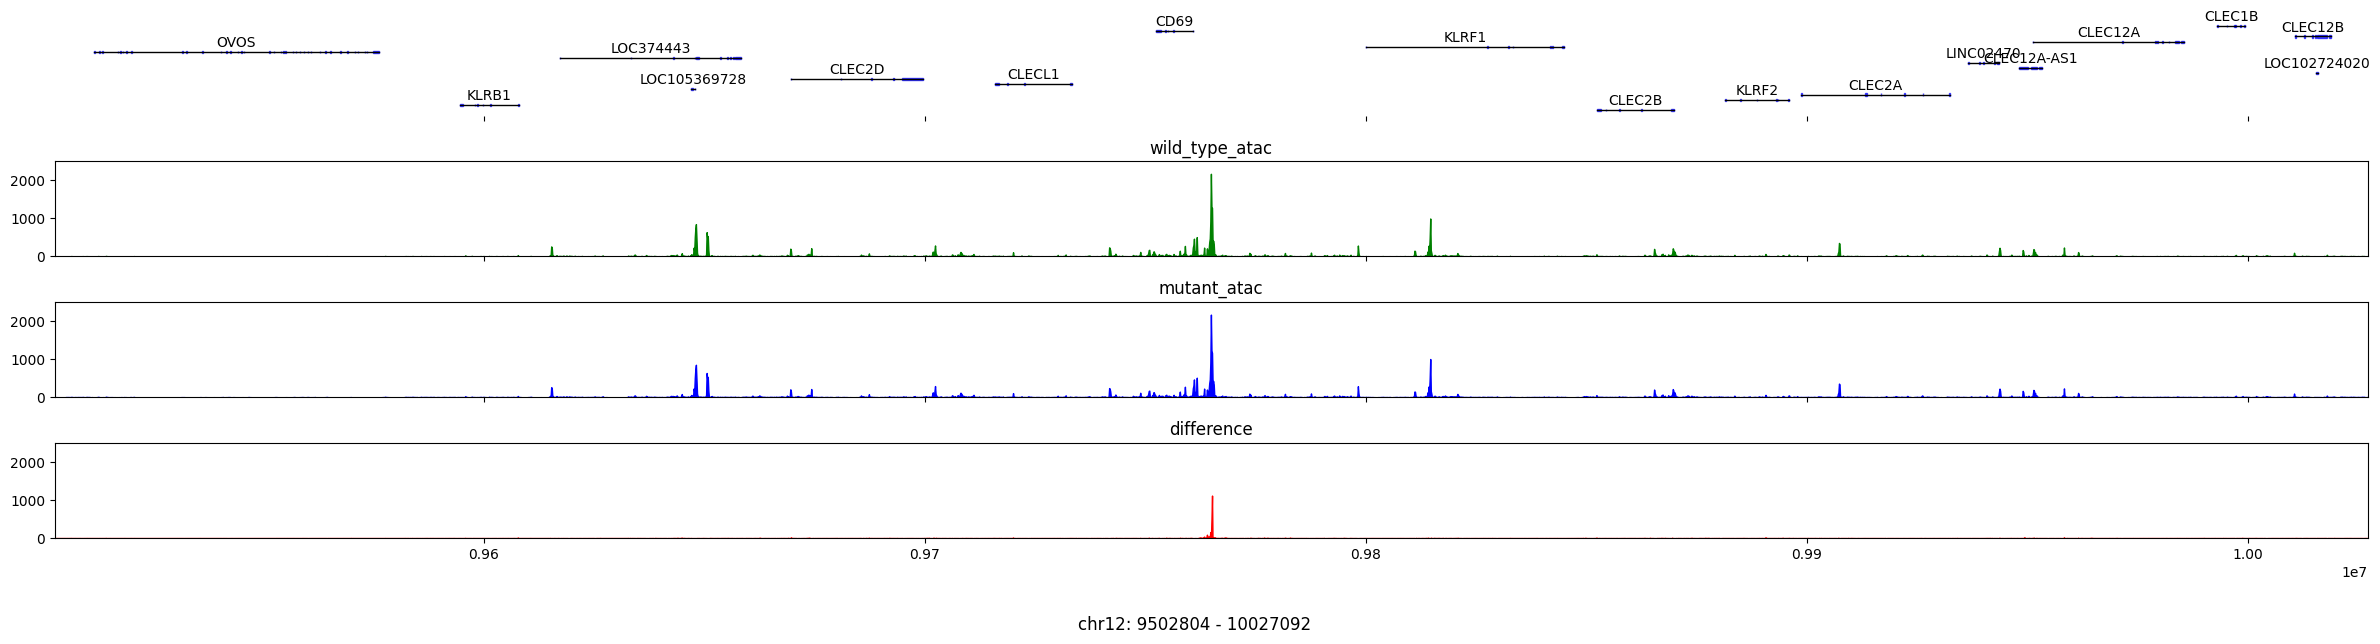

In [6]:
# plot the WT and mutant sequences, and the difference
tracks={'wild_type_atac': (output, 'green'),
        'mutant_atac': (output_mut, 'blue'),
        'difference': ((output - output_mut)*10, 'red')}
        
utils.plot_tracks_with_genes(tracks,gtf_file,interval_resize,2500) 

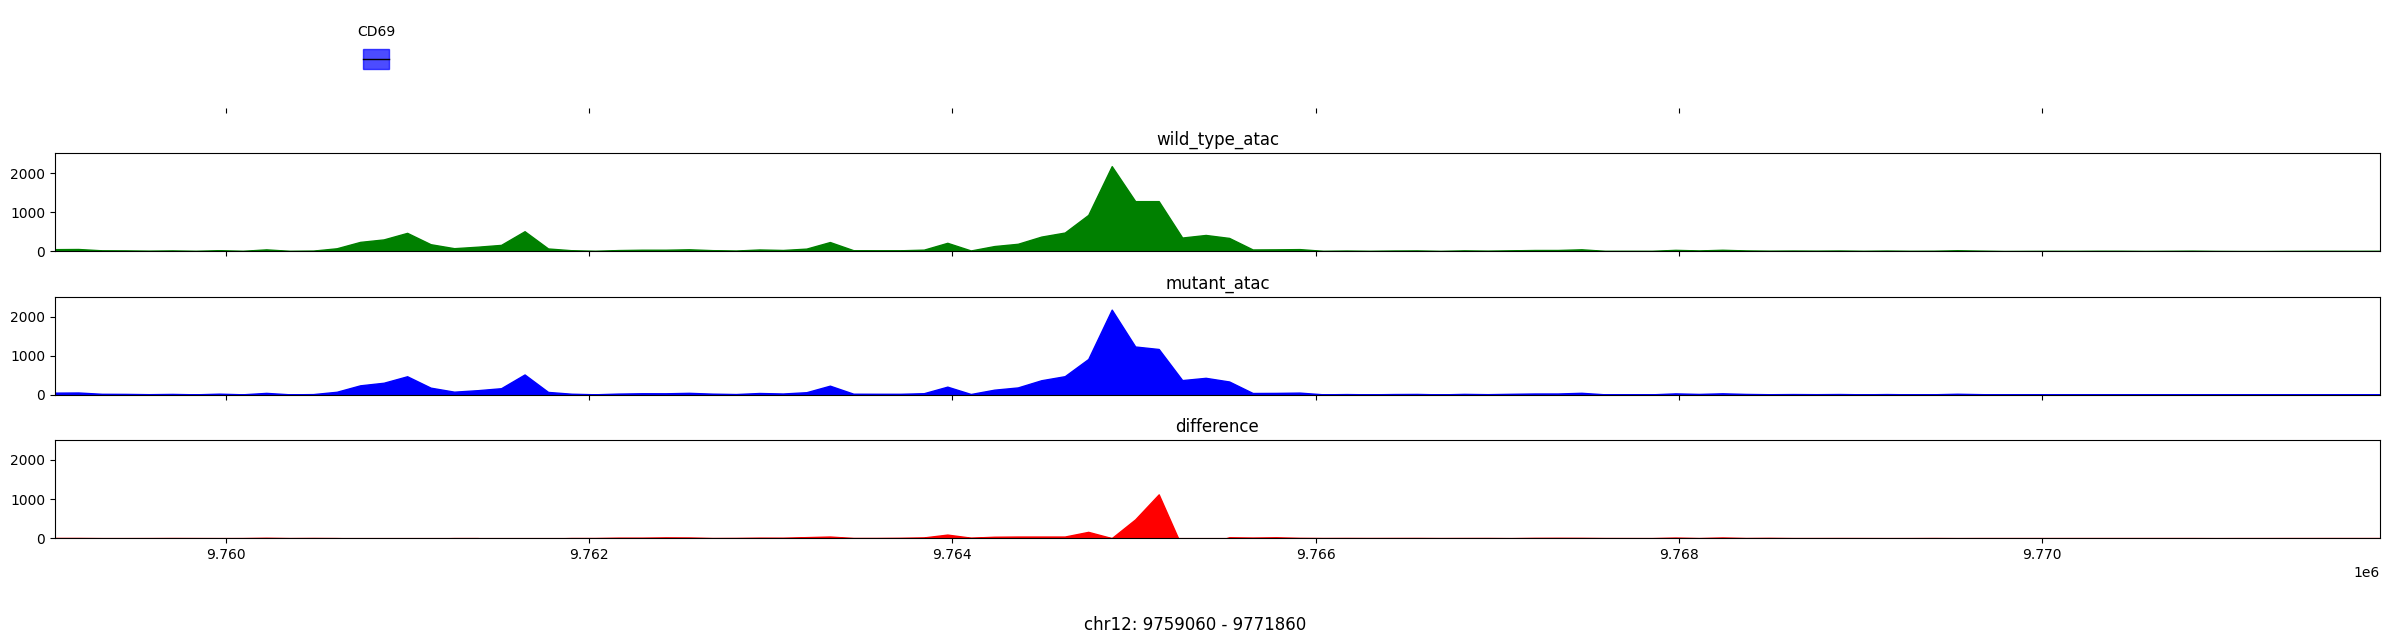

In [7]:
# zoom in to the actual variant location ( the center of the window) 
tracks={'wild_type_atac': (output[2000:2100], 'green'),
        'mutant_atac': (output_mut[2000:2100], 'blue'),
        'difference': ((output - output_mut)[2000:2100]*10, 'red')}
zoomed_interval = interval_resize[0], interval_resize[1] + 128 * (2 + 2000), interval_resize[1] + 128 * (2 + 2100)
utils.plot_tracks_with_genes(tracks,gtf_file,zoomed_interval,2500) # plot the wild type 

In [12]:
print(caqtl_score) # variant score

-72.0


In [ ]:
# score a list of variants 
variant_list = [('chr12:9764948', 'T'),
                ('chr12:9764948', 'G'),
                ('chr12:9764948', 'A'),
                ('chr12:9764958', 'C'),
                ('chr12:9764949', 'T'),
                ('chr12:9764100', 'T')]
variant_scores = {}
with tf.device('/GPU:0'): # run on GPU 
    for variant in variant_list:
        inputs, inputs_mut, masked_atac, motif,target_atac, masked_atac_reshape, mask, mask_centered,interval_resize = \
            utils.return_inputs_caqtl_score(variant, atac_file, motif_activity, fasta_extractor)
        output,output_mut,caqtl_score = genformer.ca_qtl_score(inputs,inputs_mut)
        variant_scores[variant] = caqtl_score